In [1]:
from google.colab import drive
drive.mount('/content/drive')
import shutil
shutil.copytree("drive/MyDrive/FDL/TEP","TEP")

Mounted at /content/drive


'TEP'

The training can be done on a CPU

In [1]:
import pandas as pd
norm_train = pd.read_parquet("./data/TEP_FaultFree_Training.parquet")

In [2]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, ReLU, SpatialDropout1D, Add, Dense, AveragePooling1D, Concatenate, UpSampling1D
from tensorflow.keras.models import Model
from keras.regularizers import L2

In [3]:
# Dilated conv params
kernel_size = 3
num_filters = 64
dilations = [1, 2, 4, 8, 16, 32, 64,128]
dropout_rate = 0.1
# 1x1 conv params
shrunk_dim = 32
# Pooling params
bottleneck_dim = 16
sample_rate = 10

num_features = 52

batch_size = 32

In [4]:
def dilated_conv(x, dilation_rate, filters=num_filters, kernel_size=kernel_size, dropout_rate=dropout_rate):
    x = Conv1D(filters, kernel_size, dilation_rate=dilation_rate,
               padding='causal', kernel_initializer="glorot_uniform")(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = SpatialDropout1D(dropout_rate)(x)
    return x

def onexone_conv(x, filters, kernel_size=1):
    x = Conv1D(filters=filters, kernel_size=kernel_size, padding='same', activation='linear')(x)
    return x

def encoder_layers(x, sample_rate=sample_rate, bottleneck_dim=bottleneck_dim):
    shrunk_convs = []
    for dilation in dilations:
        x = dilated_conv(x, dilation_rate=dilation)
        shrunk_convs.append(onexone_conv(x,filters=shrunk_dim))
    x = Concatenate(axis=-1)(shrunk_convs)
    x = onexone_conv(x, filters=bottleneck_dim)
    x = AveragePooling1D(pool_size=sample_rate)(x)
    return x

def decoder_layers(x, input_shape, sample_rate=sample_rate):
    x = UpSampling1D(size=sample_rate)(x)
    shrunk_convs = []
    for dilation in reversed(dilations):
        x = dilated_conv(x, dilation_rate=dilation)
        shrunk_convs.append(onexone_conv(x,filters=shrunk_dim))
    x = Concatenate(axis=-1)(shrunk_convs)
    x = onexone_conv(x, filters=input_shape[-1])
    return x

def build_tcn_ae_v0(input_shape=(None,num_features), sample_rate=sample_rate, bottleneck_dim=bottleneck_dim):
    inputs = Input(batch_shape=(None, input_shape[0], input_shape[1]))
    x = encoder_layers(inputs, sample_rate, bottleneck_dim)
    outputs = decoder_layers(x, input_shape, sample_rate)
    model = Model(inputs, outputs)
    return model

In [5]:
simulation_length = 500
num_simulations = 500
num_features = 52

y = norm_train['faultNumber'].values[::simulation_length]
X = norm_train.drop(["simulationRun","sample","faultNumber"],axis=1)
X = X.values.reshape((num_simulations, simulation_length, num_features))

In [6]:
del norm_train

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_val, _, __ = train_test_split(
    X,y, stratify=y, test_size=0.2, random_state=42
)

In [8]:
del X, y, _,__

In [9]:
import numpy as np

In [10]:
X_train_mean = np.mean(X_train, axis=(0, 1))
X_train_std = np.std(X_train, axis=(0, 1))

X_train_scaled = (X_train - X_train_mean) / X_train_std
X_val_scaled = (X_val - X_train_mean) / X_train_std

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_scaled.astype(np.float32), X_train_scaled.astype(np.float32)))
train_dataset = train_dataset.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val_scaled.astype(np.float32), X_val_scaled.astype(np.float32)))
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [12]:
model2 = build_tcn_ae_v0()

In [13]:
model2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None, 52)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, None, 64)  │     10,048 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, None, 64)  │        256 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, None, 64)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d   │ (None, None, 64)  │          0 │ re_lu[0][0]       │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, None, 64)  │     12,352 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None, 64)  │        256 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, None, 64)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_1 │ (None, None, 64)  │          0 │ re_lu_1[0][0]     │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, None, 64)  │     12,352 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None, 64)  │        256 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, None, 64)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_2 │ (None, None, 64)  │          0 │ re_lu_2[0][0]     │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, None, 64)  │     12,352 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None, 64)  │        256 │ conv1d_6[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, None, 64)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_3 │ (None, None, 64)  │          0 │ re_lu_3[0][0]     │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, None, 64)  │     12,352 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None, 64)  │        256 │ conv1d_8[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_4 (ReLU)      │ (None, None, 64)  │          0 │ batch_normalizat

 Total params: 240,964 (941.27 KB)

 Trainable params: 238,916 (933.27 KB)

 Non-trainable params: 2,048 (8.00 KB)

In [14]:
model2.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),loss="mse",metrics=["mae"])

In [15]:
from keras.callbacks import EarlyStopping

In [16]:
history2 = model2.fit(
    train_dataset, validation_data=val_dataset, epochs=30, callbacks=[keras.callbacks.ReduceLROnPlateau(patience=3),EarlyStopping(patience=10)]
)

Epoch 1/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 413ms/step - loss: 1.6107 - mae: 0.9898 - val_loss: 2148.4404 - val_mae: 28.1555 - learning_rate: 0.0100
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 270ms/step - loss: 0.8592 - mae: 0.7284 - val_loss: 164206.6875 - val_mae: 202.4668 - learning_rate: 0.0100
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 273ms/step - loss: 0.8050 - mae: 0.7016 - val_loss: 24843.1348 - val_mae: 84.8601 - learning_rate: 0.0100
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 265ms/step - loss: 0.7878 - mae: 0.6925 - val_loss: 1718.8617 - val_mae: 22.1391 - learning_rate: 0.0100
Epoch 5/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 261ms/step - loss: 0.7802 - mae: 0.6885 - val_loss: 112.9028 - val_mae: 5.8758 - learning_rate: 0.0100
Epoch 6/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 253ms/step - loss: 0.7746 - mae: 0.6855 - val_loss: 24.5221 - val_mae: 2.8866 - learning_rate: 0.0100
Epoch 7/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 255ms/step - loss: 0.7724 - mae: 0.6836 - val_loss: 5.5449 - val_mae: 1.5050 - lear

In [17]:
model2.save("./models/tcnae00x.keras")

In [ ]:
# if not re-running training
#model2 = tf.keras.models.load_model("./models/tcnae00x.keras")

After training, we want to evaluate the model. Specifically, we want to tune our threshold parameter for classifying anomalies. We will do this using a validation set comprised of 100 normal simulations and 100 (10%) anomalous ones. Although tuning via anomalous inputs is less impressive, the model will still be tested on both a normal and anomalous test set, in this way we will get information about the real performance of the tuned model.

In [18]:
X_val_scaled.shape

(100, 500, 52)

In [19]:
x_val_pred = model2.predict(X_val_scaled)

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 479ms/step


In [20]:
x_val_err = x_val_pred - X_val_scaled

In [21]:
x_val_err.shape

(100, 500, 52)

In [22]:
x_val_err[0]

array([[-0.32424539,  1.08314342,  0.93628109, ...,  0.11962834,
        -0.11237812, -0.13429586],
       [-0.34155238,  1.67191678, -0.86190723, ...,  0.15364797,
         0.1573333 , -0.76099522],
       [-0.44404105,  0.46017876,  1.23609572, ...,  0.05560526,
         0.61380775, -0.98082367],
       ...,
       [-0.00644172,  1.68467599,  1.13664419, ...,  0.08951239,
        -0.19745126, -0.7653962 ],
       [ 1.64574614, -1.90106734,  0.04900976, ...,  0.08673645,
         0.6774252 ,  0.49437437],
       [ 1.67317648, -0.96317181, -0.66287789, ...,  0.00606112,
        -0.53719305, -0.21105363]])

In [ ]:
first_sim_err = x_val_err[0] #normal inputs reconstruction

In [24]:
first_sim_err.shape

(500, 52)

Our anomaly score is the time-step wise square mean of the reconstruction error(MSE), this allows us to label single time points 

In [25]:
first_anom_score = np.mean(np.square(first_sim_err),axis=-1)

In [26]:
first_anom_score

array([0.29493355, 0.27655408, 0.54179294, 0.55250422, 0.55061269,
       0.56062749, 0.80795528, 0.56068132, 0.79341029, 0.75702089,
       0.72808097, 0.7123548 , 0.63620049, 0.85892235, 0.62912327,
       0.85450517, 1.07925848, 0.8581276 , 0.91503774, 0.63322807,
       0.40870277, 0.50162033, 0.4792005 , 0.61824554, 0.72987748,
       0.61654816, 0.79271091, 0.686838  , 0.76131791, 0.74515739,
       0.84257408, 0.69600495, 0.4320288 , 0.47335793, 0.6648912 ,
       0.77931703, 0.72917848, 0.65319787, 0.67741161, 0.84912588,
       0.72934091, 0.76742069, 0.48876511, 0.41374719, 0.65068895,
       0.63100957, 0.5528591 , 0.58422519, 0.43523603, 0.4839362 ,
       0.82893758, 0.69484035, 0.62266323, 0.76422133, 0.81865615,
       0.75207009, 0.50213407, 0.77589875, 0.67649589, 0.69123423,
       0.69018874, 0.65127813, 0.98094775, 0.93795264, 0.54024692,
       0.76662092, 0.69655326, 0.83758632, 0.65660811, 0.59806443,
       0.68610143, 0.50116533, 0.60834105, 0.60680669, 0.81623

In [27]:
np.mean(first_anom_score)

0.6928301885454872

In [28]:
np.quantile(first_anom_score,0.95)

0.984419596553816

In [29]:
import matplotlib.pyplot as plt

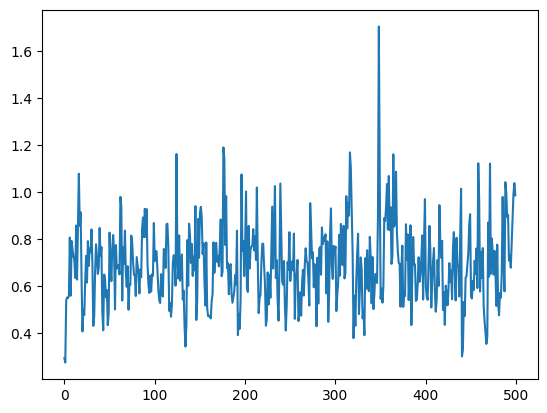

In [30]:
plt.plot(first_anom_score)

Even though this is a reconstruction of a normal sample, it might make you think that there is an anomalous point near t=350

In [31]:
reconstruction_error = np.mean(np.square(x_val_err), axis=-1)

In [32]:
reconstruction_error.shape

(100, 500)

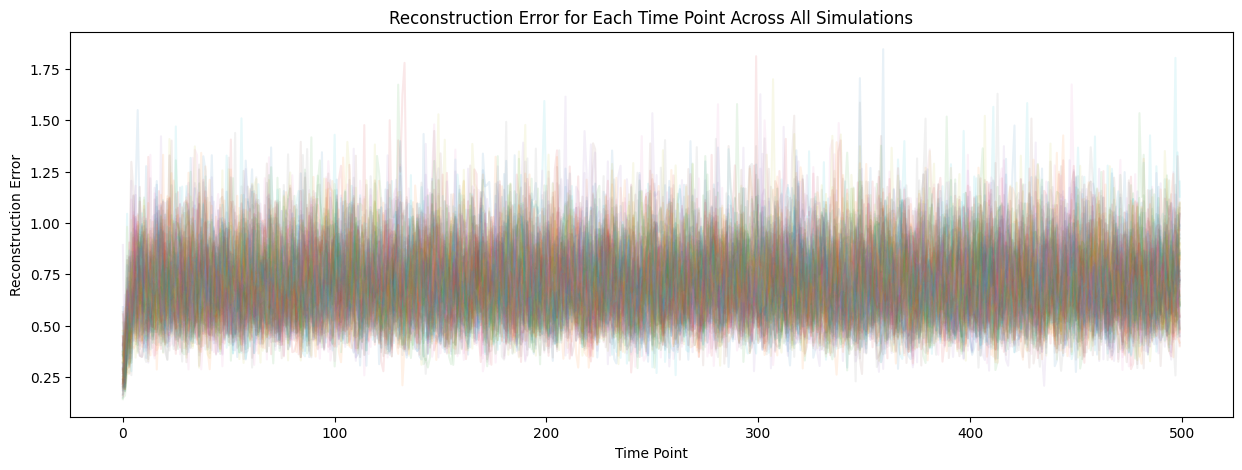

In [33]:
# Plot each time point's reconstruction error for all simulations
plt.figure(figsize=(15, 5))
plt.plot(reconstruction_error.T, alpha=0.1)
plt.title('Reconstruction Error for Each Time Point Across All Simulations')
plt.xlabel('Time Point')
plt.ylabel('Reconstruction Error')
plt.show()

In [34]:
standardized_reconstruction_error = (reconstruction_error - np.mean(reconstruction_error, axis=0)) / np.std(reconstruction_error, axis=0)

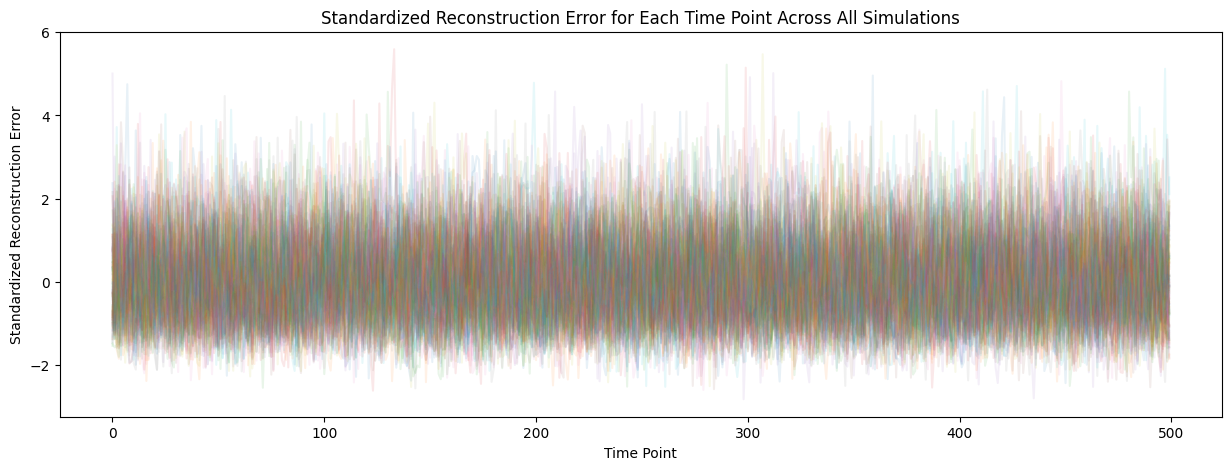

In [35]:
plt.figure(figsize=(15, 5))
plt.plot(standardized_reconstruction_error.T, alpha=0.1)
plt.title('Standardized Reconstruction Error for Each Time Point Across All Simulations')
plt.xlabel('Time Point')
plt.ylabel('Standardized Reconstruction Error')
plt.show()

Reconstruction errors for normal simulations seem to be skewed, with positive standardized values being higher than negative ones

In [37]:
anom_train = pd.read_parquet("./data/TEP_Faulty_Training.parquet")

In [38]:
anom_sub = pd.DataFrame()

We are going to draw 5 simulations at random for each anomaly type, and use thoe as our anomalous validation subset

In [39]:
import random

In [40]:
for fault in anom_train["faultNumber"].unique():
    random_runs = random.sample(range(1,500),5)
    for run in random_runs:
        anom_sub = pd.concat([anom_sub, anom_train[(anom_train["faultNumber"] == fault) & (anom_train["simulationRun"]==run)]])

In [41]:
anom_sub.shape

(50000, 55)

In [42]:
anom_sub.shape[0]/500

100.0

In [43]:
X = anom_sub.drop(["simulationRun","sample","faultNumber"],axis=1)
X = X.values.reshape((100, simulation_length, num_features))

In [44]:
X_anom_scaled = (X - X_train_mean) / X_train_std
X_anom_scaled = (X - X_train_mean) / X_train_std

In [45]:
anom_preds = model2.predict(X_anom_scaled)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


In [46]:
anom_rec_error = np.mean(np.square(anom_preds - X_anom_scaled), axis=-1)

In [47]:
anom_rec_error.shape

(100, 500)

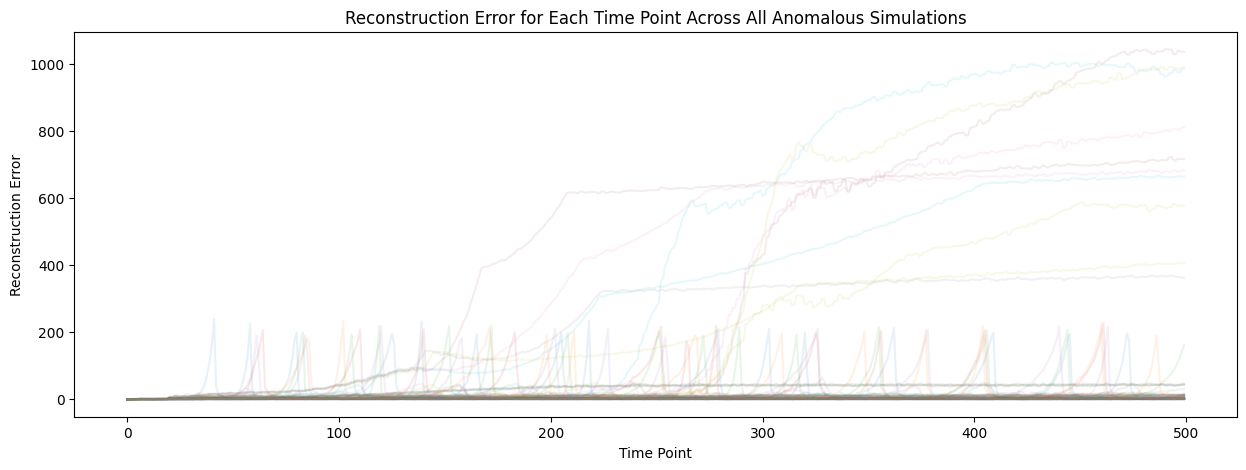

In [48]:
# Plot each time point's reconstruction error for all simulations
plt.figure(figsize=(15, 5))
plt.plot(anom_rec_error.T, alpha=0.1)
plt.title('Reconstruction Error for Each Time Point Across All Anomalous Simulations')
plt.xlabel('Time Point')
plt.ylabel('Reconstruction Error')
plt.show()

We can see the different characteristics of the anomalies through the mean squared reconstruction error. Some wildly oscillate, sum shoot upwards, but some also stay close to norma values for the most part

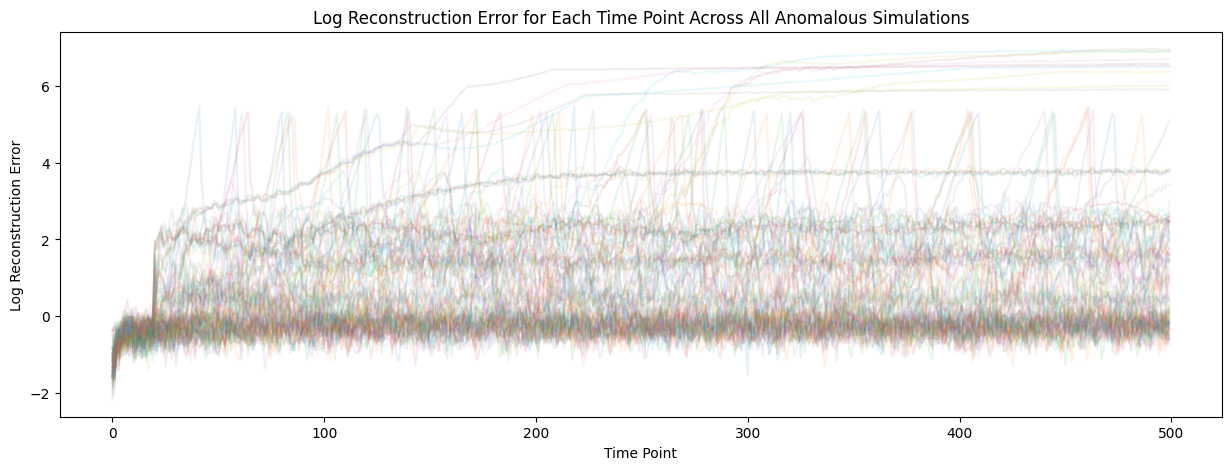

In [49]:
plt.figure(figsize=(15, 5))
plt.plot(np.log(anom_rec_error).T, alpha=0.1)
plt.title('Log Reconstruction Error for Each Time Point Across All Anomalous Simulations')
plt.xlabel('Time Point')
plt.ylabel('Log Reconstruction Error')
plt.show()

The area around 0 is dense, meaning that even after the anomaly onset we might reconstruct anomalous points with low error, given they are similar to normal points. Maybe those types of anomalies are more subtle, where the majority of variables stay normal.

Taking a look at some metrics( note: reconstruction_error is one normal sims only, while anom_rec_error is on faulty sims only)

In [50]:
anom_rec_error.min()

0.11547146909061855

In [51]:
anom_rec_error.max()

1045.1211647868047

In [52]:
anom_rec_error.mean()

37.84591254398124

In [53]:
anom_rec_error[:,:20].mean()

0.6230660955038629

In [54]:
anom_rec_error[:,20:].mean()

39.39686447933448

In [55]:
reconstruction_error.min()

0.14116735585914772

In [56]:
reconstruction_error.mean()

0.7011409607367769

In [57]:
reconstruction_error.max()

1.8468060900125616

Taking a look at reconstruction errors and the above metrics, an intuition could be to use either:
- Fixed threshold that we can validate on data here
- A dynamic thresold, obtained from estimating the distribution of the errors reconstructed(anomaly scores) with each input

This is where our data is important, we know that in most anomalies, once things go bad, they don't really go back to normal operating conditions. Unlike traditional anomaly detection where anomalies might stand out from the others, in our dataset the anomalous behavior ends up making up most of the simulations after it is introduced. So it's a good idea to ground ourselves to reconstruction errors obtained from normal simulations from a tuning validation set, given estimating a distribution or detecting anomalies on the fly from input properties could lean in favor of anomalous points.

In [58]:
norm_labels = np.zeros((100, 500))

In [59]:
anom_labels = np.zeros((100, 500))
anom_labels[:,:20] = 0
anom_labels[:,20:] = 1

One other interesting thing is that all the labels for normal simulations are the same, as well as those for anomalous ones.

There are no ground truth anomaly labels provided with the dataset, so we are making a choice to treat the data in the following way:
- Knowing when the anomaly onset happens in anomalous simulations, we set all time points' labels before that moment to 0, and we set to 1 all the subsequent time points
- Normal simulations have all-zero labels

All our anomaly scores are positive(MSE, from reconstruction error). We should find a good limit value(threshold) based on normal-input anomaly scores

On top of that, we want to know whether an anomaly was detected in an anomalous input(and the latency of the detection)

So metrics are detected(yes/no) and latency(number of time points from onset to detection)

We also care about incorrect detections i.e.
- Any detection in normal inputs(false alarm)
- Detections in anomalous inputs before actual anomaly onset
- Non-detections in anomalous inputs after anomaly onset

These simply sum up to "wrong label", but important info

In [60]:
reconstruction_error.mean()

0.7011409607367769

In [61]:
reconstruction_error.std()

0.17701741853989583

In [62]:
reconstruction_error.shape

(100, 500)

In [63]:
reconstruction_error.max()

1.8468060900125616

In [65]:
norm_labels.shape

(100, 500)

In [ ]:
threshold = 2 #testing with a simple threshold
norm_tuning = []

In [ ]:
for error in reconstruction_error:
    labels = (error > threshold).astype(int)
    norm_tuning.append((labels==norm_labels[0]).sum()/simulation_length) #if different from 1, we detected an anomaly in normal inputs

In [68]:
norm_tuning

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [69]:
anom_tuning = []

In [ ]:
for error in anom_rec_error:
    labels = (error > threshold).astype(int)
    anom_tuning.append((labels==anom_labels[0]).sum()/simulation_length)#accuracy of anomalous labels(which are mostly 1)

In [71]:
anom_tuning

[0.986,
 0.984,
 0.988,
 0.984,
 0.986,
 0.952,
 0.948,
 0.958,
 0.954,
 0.954,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.114,
 0.106,
 0.12,
 0.13,
 0.112,
 0.08,
 0.094,
 0.078,
 0.088,
 0.092,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.854,
 0.912,
 0.658,
 0.824,
 0.846,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.042,
 0.04,
 0.35,
 0.388,
 0.288,
 0.302,
 0.392,
 0.82,
 0.896,
 0.924,
 0.916,
 0.938,
 0.856,
 0.828,
 0.924,
 0.828,
 0.852,
 0.998,
 0.998,
 0.998,
 0.998,
 0.996,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.914,
 0.828,
 0.848,
 0.858,
 0.864,
 0.788,
 0.916,
 0.826,
 0.844,
 0.898,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.272,
 0.27,
 0.27,
 0.278,
 0.292]

In [72]:
np.mean(anom_tuning)

0.5146000000000001

In [ ]:
anom_rec_error[0,19:] > 2 # not detected right away..

array([False, False, False, False, False, False, False, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

For simplicity, we can restrict our priorities to the following metrics:
- Latency(first anomalous labelsafter onset, supposing we "shutdown" process if an anomaly is detected)-- so we only care about first anomaly
- False alarm rate(given we shutdown process, it's costly to be wrong) expressed as detecting anomalies in normal inputs

We can tune latency only on anomalous dataset.
Given that both anomalous and normal data are similar before anomaly onset, we can tune false alarm rate solely on normal dataset(full sequence), we could add also every anomalous input's first 20 sample from the training sets, but for simplicity this will not be done.

Note: this approach simplifies our analysis, but in this way we wont take a look at anomalous inputs being seen as anomalous before onset, something that we had mentioned earlier which is technically something wrong to infer 

In [74]:
def compute_latency(true_labels, pred_labels, onset=20):
    # Only consider time steps after onset
    for i in range(onset, len(true_labels)):
        if pred_labels[i] == 1:
            return i - onset
    return len(true_labels)  # No detection after onset(we find out at the end of the process, counts for len(sequence) latency)

In [75]:
latency_tuning = []
threshold = reconstruction_error.max() # simple threshold for testing

In [ ]:
for error in anom_rec_error:
    latency_tuning.append(compute_latency(anom_labels[0],(error > threshold).astype(int))) #latency for anomalous sims

In [ ]:
latency_tuning #500s mean we never catch it

[6,
 7,
 6,
 7,
 6,
 22,
 26,
 19,
 20,
 18,
 500,
 500,
 500,
 500,
 500,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 20,
 18,
 18,
 50,
 14,
 500,
 500,
 500,
 500,
 500,
 500,
 500,
 500,
 472,
 500,
 4,
 5,
 14,
 18,
 9,
 13,
 7,
 12,
 9,
 5,
 39,
 60,
 36,
 76,
 58,
 1,
 0,
 1,
 1,
 1,
 500,
 500,
 500,
 500,
 500,
 500,
 500,
 500,
 500,
 106,
 9,
 38,
 49,
 25,
 30,
 102,
 24,
 81,
 74,
 51,
 500,
 500,
 500,
 500,
 500,
 29,
 33,
 52,
 39,
 48]

In [78]:
np.mean(latency_tuning)

158.93

We can set up a specific metric for tuning our algorithm. Given we care about latency and FAR, we can devise something that combines the two and tells us something about our model's performance with each threshold. This results in  custom ROC curve, where we have 1-FAR on the y axis and a normalized latency measure on the x axis... naturally we want the AUC from this roc curve to be highest possible, having low latency with low FAR 

First we set up a range of thresholds, gather the performance and then visualize the outcome graphically, we can pick out interesting thresholds

In [80]:
latencies = []
false_alarm_rates = []
thresholds = []

threshold_range = np.arange(
	float(np.quantile(reconstruction_error, 0.99)), 
	3 * float(reconstruction_error.max()),
	0.05 #step value
)

for threshold in threshold_range:
    latency = []
    for error in anom_rec_error:
        latency.append(compute_latency(anom_labels[0],(error > threshold).astype(int)))
    latencies.append(np.mean(latency))

    false_alarms = []
    for error in reconstruction_error:
        labels = (error > threshold).astype(int)
        false_alarms.append((labels.sum() > 0).astype(int))
    false_alarm_rates.append(sum(false_alarms)/len(false_alarms))


In [81]:
from sklearn.metrics import auc

In [84]:
def custom_roc_curve(latencies, false_alarm_rates, thresholds, plot=True):

    latencies = np.array(latencies) # in this case, average latency
    false_alarm_rates = np.array(false_alarm_rates)
    thresholds = np.array(thresholds)

    max_latency = max(latencies)
    norm_latencies = latencies / max_latency #in this case min_latency is zero
    norm_latencies = np.clip(norm_latencies, 0, 1)
    tpr = 1 - false_alarm_rates

    # Sort by normalized latency (x-axis)
    sort_idx = np.argsort(norm_latencies)
    norm_latencies = norm_latencies[sort_idx]
    tpr = tpr[sort_idx]
    thresholds = thresholds[sort_idx]

    auc_value = auc(norm_latencies, tpr)

    if plot:
        plt.figure(figsize=(8, 6))
        plt.plot(norm_latencies, tpr, marker='o')
        plt.xlabel('Normalized Latency (0=best, 1=worst)')
        plt.ylabel('1 - False Alarm Rate')
        plt.title(f'Custom ROC Curve (AUC={auc_value:.3f})')
        plt.grid(True)
        plt.show()

    return auc_value, norm_latencies, tpr, thresholds

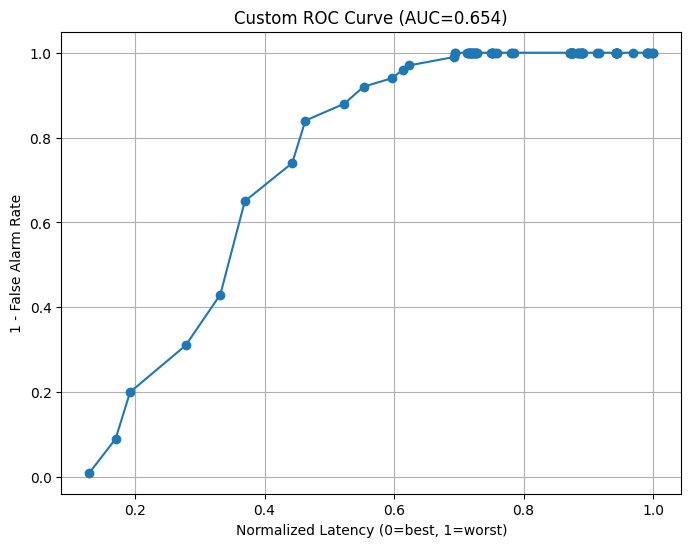

In [85]:
auc1, norm_latencies, tpr, thresholdsx= custom_roc_curve(latencies,false_alarm_rates,threshold_range)

Let's take a look athe (0 indexed) thresholds 10,12,14

In [ ]:
reconstruction_error.max() 

1.8468060900125616

In [88]:
thresholdsx[10] #not an incredible latency, but first with low false alarm rate (still not 0)

1.6917676789529184

In [89]:
norm_latencies[10]

0.5970259898831327

In [96]:
norm_latencies[10]*max(latencies)*3 #minutes

410.73

In [97]:
norm_latencies[10]*max(latencies)*3/60 #hours... not amazing

6.8455

In [94]:
thresholdsx[12]

1.7917676789529184

In [95]:
norm_latencies[12]*max(latencies)*3 #minutes

428.61

In [98]:
norm_latencies[12]*max(latencies)*3/60 #hours

7.1435

In [99]:
thresholdsx[14] # no false alarms zone, this is above max reconstruction error from normal sims

1.8917676789529185

In [101]:
norm_latencies[14]*max(latencies)*3

477.27

In [102]:
norm_latencies[14]*max(latencies)*3/60

7.9544999999999995

With that said, we can retrain our model architecture on the entire dataset, to then evaluate these candidate thresholds on the test set(s) in terms of false alarm rate and latency

In [103]:
model00 = build_tcn_ae_v0()

In [104]:
model00.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),loss="mse",metrics=["mae"])

quickly reload and preprocess the entire dataset, scaling with new means and std

In [106]:
norm_train = pd.read_parquet("./data/TEP_FaultFree_Training.parquet")
X = norm_train.drop(["simulationRun","sample","faultNumber"],axis=1)
X = X.values.reshape((num_simulations, simulation_length, num_features))
del norm_train

X_train_mean = np.mean(X, axis=(0, 1))
X_train_std = np.std(X, axis=(0, 1))

X_scaled = (X - X_train_mean) / X_train_std

train_dataset = tf.data.Dataset.from_tensor_slices((X_scaled.astype(np.float32), X_scaled.astype(np.float32)))
train_dataset = train_dataset.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [107]:
X_scaled.shape

(500, 500, 52)

In [108]:
history00 = model00.fit(
    train_dataset, epochs=30, callbacks=[keras.callbacks.ReduceLROnPlateau(patience=3,monitor="loss"),EarlyStopping(patience=10,monitor="loss")]
)

Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 25s 248ms/step - loss: 1.5587 - mae: 0.9730 - learning_rate: 0.0100
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 237ms/step - loss: 0.8370 - mae: 0.7179 - learning_rate: 0.0100
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 238ms/step - loss: 0.7961 - mae: 0.6972 - learning_rate: 0.0100
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 235ms/step - loss: 0.7806 - mae: 0.6888 - learning_rate: 0.0100
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 237ms/step - loss: 0.7727 - mae: 0.6837 - learning_rate: 0.0100
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 237ms/step - loss: 0.7631 - mae: 0.6766 - learning_rate: 0.0100
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 241ms/step - loss: 0.7578 - mae: 0.6729 - learning_rate: 0.0100
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 241ms/step - loss: 0.7550 - mae: 0.6709 - learning_rate: 0.0100
Epoch 9/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 239ms/step - loss: 0.7498 - mae: 0.6682 - learning_rate: 0.0100
Epoch 10/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 240ms/step -

In [109]:
model00.save("./models/TCNAE00.keras")

In [ ]:
# if not re-running training
#model00 = tf.keras.models.load_model("./models/TCNAE00.keras")

In [110]:
model00.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, None, 52)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_34 (Conv1D)  │ (None, None, 64)  │     10,048 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None, 64)  │        256 │ conv1d_34[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_16 (ReLU)     │ (None, None, 64)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_… │ (None, None, 64)  │          0 │ re_lu_16[0][0]    │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_36 (Conv1D)  │ (None, None, 64)  │     12,352 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None, 64)  │        256 │ conv1d_36[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_17 (ReLU)     │ (None, None, 64)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_… │ (None, None, 64)  │          0 │ re_lu_17[0][0]    │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_38 (Conv1D)  │ (None, None, 64)  │     12,352 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None, 64)  │        256 │ conv1d_38[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_18 (ReLU)     │ (None, None, 64)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_… │ (None, None, 64)  │          0 │ re_lu_18[0][0]    │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_40 (Conv1D)  │ (None, None, 64)  │     12,352 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None, 64)  │        256 │ conv1d_40[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_19 (ReLU)     │ (None, None, 64)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_… │ (None, None, 64)  │          0 │ re_lu_19[0][0]    │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_42 (Conv1D)  │ (None, None, 64)  │     12,352 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None, 64)  │        256 │ conv1d_42[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_20 (ReLU)     │ (None, None, 64)  │          0 │ batch_normalizat

 Total params: 718,798 (2.74 MB)

 Trainable params: 238,916 (933.27 KB)

 Non-trainable params: 2,048 (8.00 KB)

 Optimizer params: 477,834 (1.82 MB)